In [ ]:
pip install tensorflow


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('currentDatasetHPE.csv')
df

,index,timestamp,directory,current_space_gb
0,0,27:01.6,/info,0.97010
1,1,27:01.6,/scratch,0.01924
2,2,27:01.6,/projects,0.64564
3,3,27:01.6,/customers,0.00557
4,4,27:28.5,/info,0.97010
...,...,...,...,...
4883,4883,20:07.1,/customers,85.49830
4884,4884,30:06.1,/info,190.73985
4885,4885,30:06.1,/scratch,163.10936
4886,4886,30:06.1,/projects,59.42858


In [ ]:
# Prediction for specific directory
directory = '/info'
data = df[df['directory'] == directory][['timestamp', 'current_space_gb']].set_index('timestamp')
data


,current_space_gb
timestamp,
27:01.6,0.00557
27:28.5,0.08520
30:04.9,0.11875
40:04.5,0.04376
50:04.0,0.98132
...,...
50:16.2,83.87830
00:13.0,83.88578
10:13.2,84.60598


In [ ]:
# Scale data(Ensures that all features are on a similar scale which is required by the model)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
SEQUENCE_LENGTH = 30


**LSTM expects input in a particular shape ie (samples, time steps, features).
X.shape[0] = number of samples
X.shape[1] = sequence length
1 = number of features**

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Split into train and test sets (80% train, 20% test)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**First LSTM Layer → Captures patterns over time from sequential data.
Dropout Layer → Reduces overfitting by making the model more generalizable.
Second LSTM Layer → Refines the captured patterns and reduces dimensionality.
Final Dense Layer → Outputs the predicted next value.**

In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**1.Adam optimizer (Adaptive Moment Estimation) to adjust the weights of the model during training. 2.MSE Loss func used 3.  The model will pass through the entire training dataset 50 times to improve learning. 4. The model processes data in batches of 16 samples at a time instead of the whole dataset at once.**

In [ ]:
# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)


Since the model was trained on scaled data (range between 0 and 1), the predictions are also in the same range.
→ inverse_transform rescales them back to the original current_space_gb values

In [ ]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


In [ ]:
# Inverse transform actual values
actual = scaler.inverse_transform(y_test)

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predictions))
print(f'Root Mean Squared Error: {rmse:.4f}')

Root Mean Squared Error: 5.8196


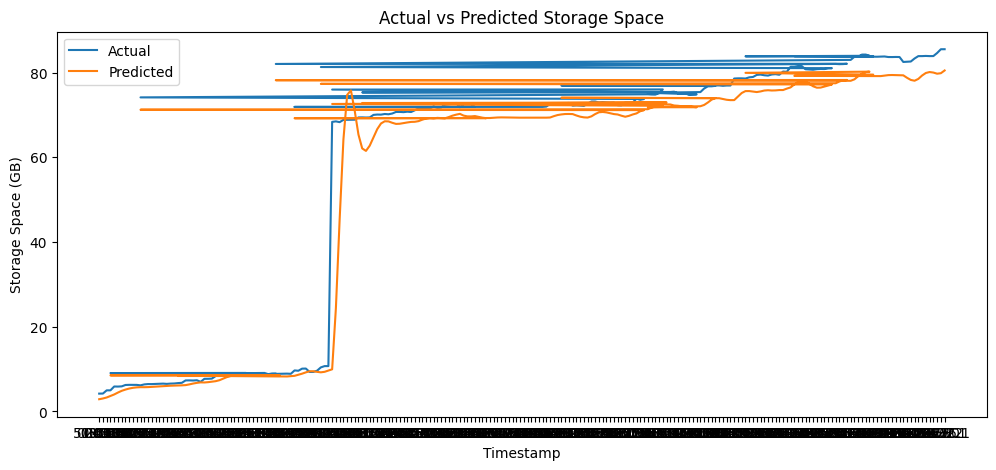

In [ ]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(data.index[-len(actual):], actual, label='Actual')
plt.plot(data.index[-len(predictions):], predictions, label='Predicted')
plt.title('Actual vs Predicted Storage Space')
plt.xlabel('Timestamp')
plt.ylabel('Storage Space (GB)')
plt.legend()
plt.show()